In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import pymcfost as mcfost
mcfost.__version__
#%matplotlib inline

#p_dirin -> directory with mcfost files .para e RT.fits.gz
#sim_para -> dict with parameters that need to be added to the header
#function that generates the post pymcfost image with added information in the header
def generateImage(p_dirin,
                  p_bmaj,
                  p_bmin,
                  p_bpa = 0,
                  p_dirout='./',
                  fileout='ris2.fits',
                  p_Jy=True,
                  p_perbeam=True,
                  p_i=0,
                  sim_para={}
                 ):
    
    image = mcfost.Image(p_dirin)
    pltimage = image.plot(i=p_i, bpa=p_bpa, bmaj=p_bmaj, bmin=p_bmin,scale='lin',Jy=p_Jy, per_beam=p_perbeam, no_ylabel=True,no_xlabel=True,plot_stars=False,limits=[0.8,-0.8,-0.8,0.8])
    header = image.header
    
    #manually updating header.BUNIT
    bunit_1 = 'W.m-2'
    bunit_2 = '.pixel-1'
    if p_Jy:
        bunit_1 = 'Jy'
    if p_perbeam:
        bunit_2 = '.beam-1'
    header['BUNIT'] = bunit_1 + bunit_2
    
    #adding simulation parameters to the header
    
    #star properties
    nstars = image.P.simu.n_stars
    header['NSTARS'] = nstars
    for i in range(0, nstars):
        header['TSTAR' + str(i)] = image.P.stars[i].Teff, 'K'
        header['MSTAR' + str(i)] = image.P.stars[i].M, 'M_sun'
        header['RSTAR' + str(i)] = image.P.stars[i].R, 'R_sun'
        
    #beam informations
    header['BMAJ'] = p_bmaj
    header['BMIN'] = p_bmin
    header['BPA'] = p_bpa, 'deg'
    
    #adding info in sim_para dict
    for key in sim_para:
        header[key] = sim_para[key]
        
    #inclination and position angle
    header['DISKPA'] = image.P.map.PA, 'deg'
    header['IMIN'] = image.P.map.RT_imin, 'deg'
    header['IMAX'] = image.P.map.RT_imax, 'deg'
    header['NI'] = image.P.map.RT_ntheta
    header['IUSED'] = p_i
    
    #distance
    header['DISTANCE'] = image.P.map.distance, 'pc'
    
    #saving fits file
    image.writeto(filename=p_dirout+'/' + fileout)
    

In [35]:
#function that extracts informations from image.log file
def get_imagelog_info(sim_para, p_dir):
    logf = open(p_dir+'/image.log')
    data = logf.read()
    
    #read gass mass and dust mass
    i_mg = data.find('gas mass')
    str_mg = data[i_mg:i_mg+data[i_mg:].find('\n')].split(' ')
    sim_para['MGAS']  = (float(str_mg[-2]), str_mg[-1])
    if str_mg[-1]!='Msun' :
        print('Error: gas mass not in M_sun units')
    i_md = data.find('dust mass')
    str_md = data[i_md:i_md+data[i_md:].find('\n')].split(' ')
    sim_para['MDUST']  = (float(str_md[-2]), str_md[-1])
    if str_md[-1]!='Msun' :
        print('Error: dust mass not in M_sun units')
        
    #read planet mass and orbital radius
    i_sink = []
    i_sink.append(data.find('Sink'))
    i_sink.append(i_sink[-1] + data[i_sink[-1]+1:].find('Sink'))
    while i_sink[-1]-i_sink[-2]!= 0:
        i_sink.append(i_sink[-1] + 1+ data[i_sink[-1]+1:].find('Sink'))
    i_sink.pop(-1)
    i_sink.pop(0)
    i_sink.append(i_sink[-1]+200)
    str_sink = [data[i_sink[i]:i_sink[i+1]] for i in range(0, len(i_sink)-1)]

    sink_index = 0
    for info in str_sink:
        if info.find('distance') > 0:
            info = " ".join(info.split())
            i_m = info.find('M')
            str_m = info[i_m:i_m+1+info[i_m+1:].find('M')+2]
            sim_para['MPLANET'+str(sink_index)] = float(str_m.split('=')[-1].split(' ')[-2]), str_m.split('=')[-1].split(' ')[-1]
            i_r = info.find('distance')
            str_r = info[i_r:i_r+1+info[i_r+1:].find('au')+2]
            sim_para['RORBP'+str(sink_index)] = float(str_r.split('=')[-1].split(' ')[-2]), str_r.split('=')[-1].split(' ')[-1]
            sink_index+=1
    sim_para['NPLANETS'] = sink_index

In [40]:
import os
import re
def read_dir_structure(parent_dir='./', beam_dims=[0.1]):
    
    #setting global parameters
    sim_para = {}
    current_dir = parent_dir
    key = 0
    out_dir = parent_dir + 'processed_fits/'
    
    #getting dir content
    dir_cont = os.listdir(parent_dir)
    
    #creating dir for the fits file that will be produced
    if 'processed_fits' not in dir_cont:
        os.mkdir(parent_dir + 'processed_fits')
        out_dir = parent_dir + 'processed_fits/'
    
    #cleaning dir content
    dir_mod = re.compile("^MP[0-9]+_time[0-9]+$")
    subdirs1 = [sd for sd in dir_cont if dir_mod.match(sd)]
    
    #cicle for /MP#_time#/ 
    for sub_dir1 in subdirs1:
        
        #getting time of simulation
        sim_para['TIME'] = int(sub_dir1.split('time')[-1]), 'planet orbits'
        
        #getting subdirs with the correct format
        dir_cont2 = os.listdir(parent_dir+sub_dir1)
        dir_mod2 = re.compile("^gd[0-9]+$")
        subdirs2 = [sd for sd in dir_cont2 if dir_mod2.match(sd)]
        
        #cicle for /MP#_time#/gd#/
        for sub_dir2 in subdirs2:
            
            #from now on using sim_para_upd to avoid
            #having to delete info that are not overrided
            sim_para_upd = sim_para 
            
            #this directory contains image.log and data_### dirs
            #updating sim_para with info contained in image.log
            get_imagelog_info(sim_para=sim_para_upd, p_dir=parent_dir+sub_dir1+'/'+sub_dir2)
            
            #searching for data_### dirs
            #getting subdirs
            dir_cont3 = os.listdir(parent_dir+sub_dir1+'/'+sub_dir2)
            dir_mod3 = re.compile("^data_[0-9]+$")
            subdirs3 = [sd for sd in dir_cont3 if dir_mod3.match(sd)]
            
            #cicle for /MP#_time#/gd#/data_#
            for sub_dir3 in subdirs3:
                
                current_dir = parent_dir + sub_dir1 + '/' + sub_dir2 + '/' + sub_dir3 + '/'
                
                for beam_dim in beam_dims:
                    
                    #generate file name
                    key_str = str(key).zfill(5)
                    wave_str = sub_dir3.split('data_')[-1]
                    out_filename = key_str + sub_dir1 + sub_dir2 + 'W' + wave_str + 'B' + str(beam_dim).split('.')[-1] + '.fits'
                    
                    generateImage(current_dir, p_bmaj=beam_dim, p_bmin=beam_dim, p_dirout=out_dir, fileout=out_filename, sim_para=sim_para_upd)
                    key+=1

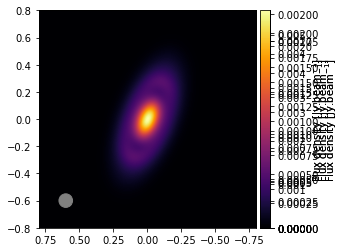

In [41]:
parent_dir='../simulazioni/'
read_dir_structure(parent_dir=parent_dir)

TODOs:

    - add some output 
    - find a way to not plot images inline
    - if processed_fits dir already exist restart from last key
    - add a way to skip already processed data
    
    - study possible values for beam_size
    - update doc
    - add info on T and opacity
    
    - improve get_imagelog_info() with the use of re

OSError: File 'fit7.fits' already exists.

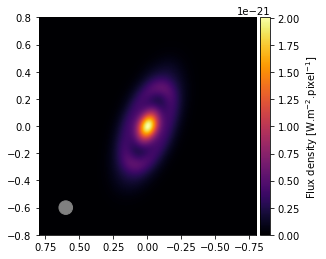

In [287]:
#usage of the 2 functions above
p_dir = 'fitsFile'
sim_para = {}
get_imagelog_info(sim_para, p_dir)
processimage(p_dirin=p_dir+'/data_1300/data_1300/', p_dirout='./', fileout='fit7.fits', p_bpa=0, p_bmaj=0.1, p_bmin=0.1, p_Jy=False, p_perbeam=False, p_i=0, sim_para=sim_para)

In [223]:
filegen = fits.open('fit7.fits')
filegen.info()

Filename: fit7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1024, 1024)   float64   


In [224]:
filegen[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WAVE    =                1300. / wavelength [microns]                           
CTYPE1  = 'RA---TAN'                                                            
CRVAL1  =                   0. / RAD                                            
CRPIX1  =                  513                                                  
CDELT1  =        -5.118252E-07 / pixel scale x [deg]                            
CUNIT1  = 'deg     '        

In [273]:
import re
prova = ['MP001_time66', 'MP001_time664', 'altro', 'MP001_time661']
dir_mod = re.compile("MP[0-9]+_time[0-9]+")
provafilt = [str for str in prova if dir_mod.match(str)]
provafilt

['MP001_time66', 'MP001_time664', 'MP001_time661']

In [264]:
print(dom)

<re.Match object; span=(0, 12), match='MP001_time66'>


In [283]:
str1

'fkf'

In [3]:
datat = 'dat1300'
datat.split('dat')[-1]

'1300'

SyntaxError: invalid digit '4' in binary literal (<ipython-input-14-03d93541b325>, line 1)

In [29]:
sprove = 'data_1300'
dir_mod3 = re.compile("^data_[0-9]+$")
print(dir_mod3.match(sprove))

<re.Match object; span=(0, 9), match='data_1300'>
